In [1]:
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt
from jinja2 import Template
from pyne import data
from pyne.material import Material
from pyne import serpent
from pyne import nucname
import pdb

ModuleNotFoundError: No module named 'pyne'

First we want the helium density in $10^24$ atoms per cc.

\begin{align}
PV&=nRT\\
\frac{n}{V}&=\frac{P}{RT}
\end{align}

In [2]:

R = 8.314 # j/k-mol
temp = [250 ,750] #celsius
pres = [6*10**6, 5.84*10**6] #pascals
hedensity = np.zeros(len(temp))


for i, t in enumerate(temp):
    hedensity[i] = ((pres[i])/((t+273.15)*R)) # mol/m^3 

hedensavg = np.sum(hedensity)/len(hedensity)*(6.022*10**-7)# 10^24/cc

print(hedensavg)

0.000622077124202638


### Isotopic composition of the fuel

The enrichment of the UCO kernels in the TRISO particles is known.  Additionally, we know the molar contentrations of the three compounds that make UCO: $UO_2$ , $UC$, and $UC_{1.86}$. The [PyNE](https://pyne.io/) python library is used to create the material cards for the fuel.
<br>
UCO is created from $UO_2$, $UC$, and $UC_{1.86}$ in molar concentrations of 0.714, 0.164, and 0.123, respectively.

In [3]:
leu = Material({'U235': 0.1975 , 'U238': 0.8025})
uo2 = Material()
uc = Material()
uc186 = Material()

uo2.from_atom_frac({'O16': 2.0 , leu :1.0})
uc.from_atom_frac({'C12':1, leu: 1.0})
uc186.from_atom_frac({'C12':1.86, leu : 1.0})

uco = Material()
uco.from_atom_frac({uo2: 0.714, uc: 0.164, uc186: 0.123})
print(uco.mcnp()) #the negative values for composition mean it is mass fraction, just like serpent


m?
     6012 -1.7770e-02
     8016 -8.6113e-02
     92235 -1.7698e-01
     92238 -7.1913e-01



/home/zoe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  """Entry point for launching an IPython kernel.


In order to find the core dimensions, I used an image of the reactor core given in a public presentation to the NRC.  
<br>
Then, I opened it in an image viewer that gave the cursor's coordinates in pixels, measured the reactor core features in pixels.  Knowing the outer core diameter, developed a scale between pixels and meters, and used that to determine the core geometry.

\begin{align}
s (\frac{cm}{px}) = 100* \frac{RPV_D (m)}{RPV_D (px)}\\
x (cm) = x (px) * scale
\end{align}

In [4]:
core_dm = 4.88 # m
core_dpx = 69 #px
scale = core_dm/core_dpx *100 # cm/px

inner_corerad_px = 17.5
inner_corerad_cm = inner_corerad_px *scale
reflect_px = 13
reflect_cm = reflect_px *scale

print(2*(reflect_cm+inner_corerad_cm)) #can't be more than 488, which is the diameter including RPV
print()
print(inner_corerad_cm)
print(reflect_cm)
print(inner_corerad_cm+reflect_cm)

431.4202898550724

123.76811594202897
91.94202898550724
215.7101449275362


I found the midpoint of the cones on the top and bottom , and used the distance between these two midpoints as an adjusted height.  Then, I simplified by letting the reflector directly surround this region.

### Creating the input file

The first step to creating the input file is to create the pebble and particle location input cards.  This can be done using serpent's built in particle dispersal routine, which takes the dimensions of the particle, the volume they are dispersed in, and the particle number or packing fraction, the universe the particles are in, and creates a plain text file, where each line is:

\begin{align}
x-coordinate\ \ y-coordinate\ \  z-coordinate\ \  universe
\end{align}

In order to split the automatically generated distribution file into several sub-files for modeling different fuel compositions, the cell below splits a given text file into multiple.  It can also append a character to the universe name, if needed.

In [2]:
origin = open('htgr-20/geometry-tests/all-pebbs.inp','r')

filenames = ['pbbls-20-0.inp','pbbls-20-1.inp','pbbls-20-2.inp','pbbls-20-3.inp','pbbls-20-4.inp','pbbls-20-5.inp','pbbls-20-6.inp']

lines = 0
for line in list(origin):
    lines += 1
origin.seek(0)
i = 0

file = ['f0','f1','f2','f3','f4','f5','f6']
for index, name in enumerate(filenames):
    file[index] = open(name,'a+')
subuniverse = ['a','b','c','d']    
    
while i < lines:
    for index, f in enumerate(file):
        #use lines below if you need to append a new character to universe name
        #newline = origin.readline()
        #f.write(newline[:-1] + subuniverse[index] + newline[-1:])
        f.write(origin.readline())
        i += 1
        if i == lines:
            break
for f in file:
    f.close()
origin.close()

After the above is used to create the input file, it is run in the terminal with Serpent 2.1.31

In [10]:
dep = serpent.parse_dep('../single-pebble/burn-20/htgr-mr-burn-20.inp_dep.m')

In [20]:
mats = dep['MAT_fuel_MATERIAL']
#mats[1].comp.keys
newdict = {nucname.serpent(k): v for k,v in mats[6].comp.items()}

for k,v in newdict.items():
    print('{}.08c'.format(k),"     " ,v)

H-1.08c       1.4039761314610683e-08
H-2.08c       8.575872266426048e-09
H-3.08c       1.7809450461743885e-07
He-3.08c       2.403414454964853e-09
He-4.08c       4.1936188654818196e-06
Li-6.08c       3.7024814426859424e-08
Li-7.08c       1.3328754919071045e-08
Be-9.08c       3.1081994308479828e-09
B-10.08c       2.3048449742374247e-09
B-11.08c       4.931884902411149e-10
C-nat.08c       0.017770521110676857
N-14.08c       2.1979529803730034e-12
N-15.08c       1.618496866254497e-09
O-16.08c       0.08611036021385192
O-17.08c       2.766667140376986e-08
Ca-46.08c       6.52385887434054e-26
Ca-48.08c       1.5542179587800361e-30
Ti-47.08c       1.0258065919017555e-23
Ti-48.08c       1.5385370706399525e-24
Ti-49.08c       1.8358918241640898e-17
Ti-50.08c       9.113288319649272e-15
Cr-52.08c       3.286683228976092e-14
Cr-53.08c       6.121212960079972e-14
Cr-54.08c       1.178486051483799e-13
Mn-55.08c       2.0837389940765826e-13
Fe-56.08c       4.405310855372948e-13
Fe-57.08c       1.19

In [7]:
serpent.parse_res('../full-core/htgr-20/htgr-20-full-core.inp_res.m')

{'np': <module 'numpy' from '/home/zoe/anaconda3/lib/python3.7/site-packages/numpy/__init__.py'>,
 'TOT_FLUX': array([[9.3077e+02, 3.5800e-03]]),
 'TOT_CUTRATE': array([[0., 0.]]),
 'PU239_CAPT': array([[0.0191427, 0.02283  , 0.0424034, 0.02234  ]]),
 'ANA_INV_SPD': array([[1.51219e-06, 2.35000e-03]]),
 'RES_MEMSIZE': array([30.69]),
 'URES_DILU_CUT': array([1.e-09]),
 'SRC_NORM_MODE': array([2]),
 'TOT_RR': array([[3.1922e+02, 4.5900e-03]]),
 'ANA_EALF': array([[1.78105e-07, 1.31000e-02]]),
 'TOT_NUCLIDES': array([316]),
 'PU240_FISS': array([[1.91763e-05, 7.03540e-01, 4.48023e-05, 7.03600e-01]]),
 'ADJ_NAUCHI_LIFETIME': array([[0.00100877, 0.00856   , 0.00100924, 0.00871   , 0.00082817,
         0.12952   ]]),
 'TOT_SF_RATE': array([0.]),
 'ANA_THERM_TIME': array([[0.00182407, 0.00564   , 0.0018247 , 0.00566   , 0.00169437,
         0.08766   ]]),
 'TOT_CELLS': array([4]),
 'ELECTRON_DECAY_SOURCE': array([0.]),
 'VERSION': array([b'Serpent 2.1.31'], dtype='|S14'),
 'REA_SAMPLING_EFF'

In [22]:
fuel = (4/3)*np.pi*(0.02125**3)*(18000)
pyroc = 18000*( ((4/3)*np.pi*(0.03475**3) - 
                 (4/3)*np.pi*(0.03075**3))
         + ( (4/3)*np.pi*(0.04225**3) - 
            (4/3)*np.pi*(0.03828**3) ))
sic = ((4/3)*np.pi*(0.03825**3) - (4/3)*np.pi*(0.03475**3))*18000

graph = ((4/3)*np.pi*(3.0**3)) - fuel - pyroc - sic

tot = (4/3)*np.pi*(3.0**3)

In [23]:
print(fuel/tot)
print(pyroc/tot)
print(sic/tot)
print(graph/tot)

0.006397135416666668
0.021474480715333345
0.009332895833333325
0.9627954880346667


In [24]:
(fuel+pyroc+sic+graph)/tot

1.0

$$\text{Power Density} = \frac{kW}{g_{fuel}} $$

For 200 MWth:

$$\text{Power Density} = \frac{200*1000}{\frac{4}{3} \pi 0.02125^3*220000*18000} = 0.11 $$

Therefore, for 20 MWth

$$ 0.11 {kW/g} = \frac{20*1000}{m_{fuel}}$$

$$m_{fuel} = 181818.18 [g]$$

$$V_{fuel,core} = \frac{m_{fuel}[g]}{\rho_{fuel}[\frac{g}{cc}]} = \frac{181818.18}{11.0} = 16528.92 [cc]$$

$$ V_{fuel,pebble} = 18000 * \frac{4}{3} \pi 0.02125^{3} = 0.7235$$

$$ n_{pebbles} = \frac{V_{fuel,core}}{V_{fuel,pebble}} = \frac{16528.92}{0.7235} = 22846 $$

$\phi$, the packing fraction, is the ratio of the objects in a 3-D space to the volume of that space, and for a random pack, between 0.56 and 0.60 are acceptable:

$$ \phi = \frac{22846 * \frac{4}{3}\pi r_{pebble}^3}{V_{core}} = [0.56,0.58,0.60] $$

$$ V_{core} = [4306369.55, 4454865.05, 4613967.37] = H_{core} * \pi * R_{core}^{2} $$

$$ H = \frac{V}{\pi*R^{2}} $$

In [5]:
t_vol_peb = 22846*4/3*np.pi*3.0**3
print(t_vol_peb/0.60)
print(t_vol_peb/0.58)
print(t_vol_peb/0.56)

4306369.545834744
4454865.047415253
4613967.370537226


214.18125020716278
221.56681047338233
229.47991068756625


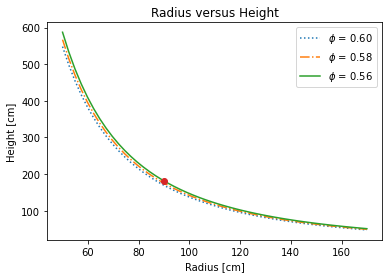

In [13]:
R = np.linspace(50,170)
H060 = 4306369.55/(np.pi*R**2)
H058 = 4454865.05/(np.pi*R**2)
H056 = 4613967.37/(np.pi*R**2)
print(4306369.55/(np.pi*80**2))
print(4454865.05/(np.pi*80**2))
print(4613967.37/(np.pi*80**2))
plt.plot(R,H060, linestyle = ':')
plt.plot(R,H058, linestyle = '-.')
plt.plot(R,H056)
plt.plot(90,180, marker = 'o')
plt.title('Radius versus Height')
plt.xlabel('Radius [cm]')
plt.ylabel('Height [cm]')
plt.legend(['$\phi$ = 0.60','$\phi$ = 0.58','$\phi$ = 0.56'])

In order to determine the outward surface current, the result for the current given by Serpent's surface detector must be divided by the surface area of the detector, to get units of $\frac{n}{cm^2s}$

In [3]:
r20det = 164 #detector radius, cm
h20det = 2*164 #detector height, cm

sa20det = (2*r20det*np.pi*h20det)+ 2*(np.pi*r20det**2) #detector surface area, cm

print(sa20det)

506977.6560657064


The formula for the outward current at the reflector surface is then
$$ J^+[\frac{n}{cm^2s}] = \frac{J^+[\frac{n}{s}]}{S_{det}[cm^2]} $$
The error becomes:
$$ \delta J^+[\frac{n}{cm^2s}] = |\frac{1}{S_{det}}|\delta J^+[\frac{n}{s}] $$

For the values below, the model run was:

- 20 MWth core
- 65 cm reflector thickness on sides and top, for a current surface detector radius of 164 cm, and a height of 328 cm
- 50,000 neutrons, 100/50 active/inactive cycles
- A $\frac{1}{6}$ slice of the core is used with a periodic boundary condition


In [4]:
J_0_60 = 3.002 * 10**17
delJ_0_60 = 0.00147
J_0_60c = J_0_60/sa20det
delJ_0_60c = delJ_0_60/sa20det
print("0-60: " + "{:.3e}".format(J_0_60c) + " +/- " + "{:.3e}".format(delJ_0_60c))
print()

J_60_120 = 2.983 * 10**17
delJ_60_120 = 0.00141
J_60_120c = J_60_120/sa20det
delJ_60_120c = delJ_60_120/sa20det
print("60-120: " + "{:.3e}".format(J_60_120c) + " +/- " + "{:.3e}".format(delJ_60_120c))
print()

J_120_180 = 2.995 * 10**17
delJ_120_180 = 0.00126
J_120_180c = J_120_180/sa20det
delJ_120_180c = delJ_120_180/sa20det
print("120-180: " + "{:.3e}".format(J_120_180c) + " +/- " + "{:.3e}".format(delJ_120_180c))
print()

J_180_240 = 2.996 * 10**17
delJ_180_240 = 0.00147
J_180_240c = J_180_240/sa20det
delJ_180_240c = delJ_180_240/sa20det
print("180-240: " + "{:.3e}".format(J_180_240c) + " +/- " + "{:.3e}".format(delJ_180_240c))
print()

J_240_300 = 2.983 * 10**17
delJ_240_300 = 0.00151
J_240_300c = J_240_300/sa20det
delJ_240_300c = delJ_240_300/sa20det
print("240-300: " + "{:.3e}".format(J_240_300c) + " +/- " + "{:.3e}".format(delJ_240_300c))
print()

J_300_360 = 2.985 * 10**17
delJ_300_360 = 0.00144
J_300_360c = J_300_360/sa20det
delJ_300_360c = delJ_300_360/sa20det
print("300-360: " + "{:.3e}".format(J_300_360c) + " +/- " + "{:.3e}".format(delJ_300_360c))
print()


0-60: 5.921e+11 +/- 2.900e-09

60-120: 5.884e+11 +/- 2.781e-09

120-180: 5.908e+11 +/- 2.485e-09

180-240: 5.910e+11 +/- 2.900e-09

240-300: 5.884e+11 +/- 2.978e-09

300-360: 5.888e+11 +/- 2.840e-09



A control run was also made, with all parameters the same as the model the slices came from, but I full core model instead.  The resulting outer $J^+$ is:

In [5]:
J_20 = 2.39232E+17
delJ_20 = 0.00135
J_20c = J_20/sa20det
delJ_20c = delJ_20/sa20det
print("Full 20 MWth Core: " + "{:.3e}".format(J_20c) + " +/- " + "{:.3e}".format(delJ_20c))
print()

Full 20 MWth Core: 4.719e+11 +/- 2.663e-09



In [6]:
diff20_0_60 = (J_0_60c - J_20c)/(J_20c)*100 # in %
print("{:.3f}".format(abs(diff20_0_60)) + "% from control")

diff20_60_120 = (J_60_120c - J_20c)/(J_20c)*100 # in %
print("{:.3f}".format(abs(diff20_60_120)) + "% from control")


diff20_120_180 = (J_120_180c - J_20c)/(J_20c)*100 # in %
print("{:.3f}".format(abs(diff20_120_180)) + "% from control")


diff20_180_240 = (J_180_240c - J_20c)/(J_20c)*100 # in %
print("{:.3f}".format(abs(diff20_180_240)) + "% from control")


diff20_240_300 = (J_240_300c - J_20c)/(J_20c)*100 # in %
print("{:.3f}".format(abs(diff20_240_300)) + "% from control")


diff20_300_360 = (J_300_360c - J_20c)/(J_20c)*100 # in %
print("{:.3f}".format(abs(diff20_300_360)) + "% from control")

25.485% from control
24.691% from control
25.192% from control
25.234% from control
24.691% from control
24.774% from control


The same exercise was performed as above for testing the sensitivity of the model to the pebble burnup locations (the model still uses a 1/6 symmetry).  The locations of the pebbles stayed the same, but had different burnups assigned to them, as follows:

Original (Run 1): <br>

Positions "0":  Burnup 0 <br>
Positions "1":  Burnup 1 <br>
Positions "2":  Burnup 2 <br>
Positions "3":  Burnup 3 <br>
Positions "4":  Burnup 4 <br>
Positions "5":  Burnup 5 <br>
Positions "6":  Burnup 6 <br>

This model is identical to the 0-60 slice run described above.  To change the level of the burnup locations, subsequent runs had the pebble compositions re-assigned as follows:

Run 2: <br>

Positions "0":  Burnup 6 <br>
Positions "1":  Burnup 0 <br>
Positions "2":  Burnup 1 <br>
Positions "3":  Burnup 2 <br>
Positions "4":  Burnup 3 <br>
Positions "5":  Burnup 4 <br>
Positions "6":  Burnup 5 <br>

Run 3: <br>

Positions "0":  Burnup 5 <br>
Positions "1":  Burnup 6 <br>
Positions "2":  Burnup 0 <br>
Positions "3":  Burnup 1 <br>
Positions "4":  Burnup 2 <br>
Positions "5":  Burnup 3 <br>
Positions "6":  Burnup 4 <br>

Run 4: <br>

Positions "0":  Burnup 4 <br>
Positions "1":  Burnup 5 <br>
Positions "2":  Burnup 6 <br>
Positions "3":  Burnup 0 <br>
Positions "4":  Burnup 1 <br>
Positions "5":  Burnup 2 <br>
Positions "6":  Burnup 3 <br>

Run 5: <br>

Positions "0":  Burnup 3 <br>
Positions "1":  Burnup 4 <br>
Positions "2":  Burnup 5 <br>
Positions "3":  Burnup 6 <br>
Positions "4":  Burnup 0 <br>
Positions "5":  Burnup 1 <br>
Positions "6":  Burnup 2 <br>

Run 6: <br>

Positions "0":  Burnup 2 <br>
Positions "1":  Burnup 3 <br>
Positions "2":  Burnup 4 <br>
Positions "3":  Burnup 5 <br>
Positions "4":  Burnup 6 <br>
Positions "5":  Burnup 0 <br>
Positions "6":  Burnup 1 <br>

Run 7: <br>

Positions "0":  Burnup 1 <br>
Positions "1":  Burnup 2 <br>
Positions "2":  Burnup 3 <br>
Positions "3":  Burnup 4 <br>
Positions "4":  Burnup 5 <br>
Positions "5":  Burnup 6 <br>
Positions "6":  Burnup 0 <br>

The detector size didn't change from the previous runs, so the conversion to $[\frac{n}{cm^2s}]$ is simple.


In [7]:
J_0_60 = 3.002 * 10**17
delJ_0_60 = 0.00147
J_0_60c = J_0_60/sa20det
delJ_0_60c = delJ_0_60/sa20det
print("Run 1: " + "{:.3e}".format(J_0_60c) + " +/- " + "{:.3e}".format(delJ_0_60c))
print()

J_r2 = 2.995 * 10**17
delJ_r2 = 0.00155
J_r2c = J_r2/sa20det
delJ_r2c = delJ_r2/sa20det
print("Run 2: " + "{:.3e}".format(J_r2c) + " +/- " + "{:.3e}".format(delJ_r2c))
print()

J_r3 = 2.985 * 10**17
delJ_r3 = 0.00131
J_r3c = J_r3/sa20det
delJ_r3c = delJ_r3/sa20det
print("Run 3: " + "{:.3e}".format(J_r3c) + " +/- " + "{:.3e}".format(delJ_r3c))
print()

J_r4 = 2.994 * 10**17
delJ_r4 = 0.00144
J_r4c = J_r4/sa20det
delJ_r4c = delJ_r4/sa20det
print("Run 4: " + "{:.3e}".format(J_r4c) + " +/- " + "{:.3e}".format(delJ_r4c))
print()

J_r5 = 3.006 * 10**17
delJ_r5 = 0.00139
J_r5c = J_r5/sa20det
delJ_r5c = delJ_r5/sa20det
print("Run 5: " + "{:.3e}".format(J_r5c) + " +/- " + "{:.3e}".format(delJ_r5c))
print()

J_r6 = 3.011 * 10**17
delJ_r6 = 0.00132
J_r6c = J_r6/sa20det
delJ_r6c = delJ_r6/sa20det
print("Run 6: " + "{:.3e}".format(J_r6c) + " +/- " + "{:.3e}".format(delJ_r6c))
print()

J_r7 = 3.016 * 10**17
delJ_r7 = 0.00133
J_r7c = J_r7/sa20det
delJ_r7c = delJ_r7/sa20det
print("Run 7: " + "{:.3e}".format(J_r7c) + " +/- " + "{:.3e}".format(delJ_r7c))
print()

Run 1: 5.921e+11 +/- 2.900e-09

Run 2: 5.908e+11 +/- 3.057e-09

Run 3: 5.888e+11 +/- 2.584e-09

Run 4: 5.906e+11 +/- 2.840e-09

Run 5: 5.929e+11 +/- 2.742e-09

Run 6: 5.939e+11 +/- 2.604e-09

Run 7: 5.949e+11 +/- 2.623e-09



These results can be compared to the control, as before, using the relative difference...

In [8]:
diff20_0_60 = (J_0_60c - J_20c)/(J_20c)*100 # in %
print("{:.3f}".format(abs(diff20_0_60)) + "% from control")

diff20_r2 = (J_r2c - J_20c)/(J_20c)*100 # in %
print("{:.3f}".format(abs(diff20_r2)) + "% from control")


diff20_r3 = (J_r3c - J_20c)/(J_20c)*100 # in %
print("{:.3f}".format(abs(diff20_r3)) + "% from control")


diff20_r4 = (J_r4c - J_20c)/(J_20c)*100 # in %
print("{:.3f}".format(abs(diff20_r4)) + "% from control")


diff20_r5 = (J_r5c - J_20c)/(J_20c)*100 # in %
print("{:.3f}".format(abs(diff20_r5)) + "% from control")


diff20_r6 = (J_r6c - J_20c)/(J_20c)*100 # in %
print("{:.3f}".format(abs(diff20_r6)) + "% from control")

diff20_r7 = (J_r7c - J_20c)/(J_20c)*100 # in %
print("{:.3f}".format(abs(diff20_r7)) + "% from control")

25.485% from control
25.192% from control
24.774% from control
25.150% from control
25.652% from control
25.861% from control
26.070% from control


The reflector thickness is chosen such that the outward surface current is less than or equal to the outward current of the 200MWth design.  The outward current for this design can be, as above, found by dividing the surface current given in the Serpent output, in $[\frac{n}{s}]$, by the surface area of the detector.  Thus, the "target" current is:

In [9]:
r200det = 215 #detector radius, cm
h200det = 2*574 #detector height, cm

sa200det = (2*r200det*np.pi*h200det)+ 2*(np.pi*r200det**2) #detector surface area, cm

J_200 = 1.35352 * 10**18
delJ_200 = 0.00130
J_200c = J_200/sa200det
delJ_200c = delJ_200/sa200det
print("200MWth full core: " + "{:.3e}".format(J_200c) + " +/- " + "{:.3e}".format(delJ_200c))

200MWth full core: 7.351e+11 +/- 7.060e-10


The relative difference is simply
$$ \frac{J^+_{200} - J^+_{20}}{J^+_{200}} $$

In [10]:
diff_0_60 = (J_0_60c - J_200c)/(J_200c)*100 # in %
if diff_0_60 < 0:
    print("{:.3f}".format(abs(diff_0_60)) + "% decrease")
else:
    print("{:.3f}".format(abs(diff_0_60)) + "% increase")


diff_60_120 = (J_60_120c - J_200c)/(J_200c)*100 # in %
if diff_60_120 < 0:
    print("{:.3f}".format(abs(diff_60_120)) + "% decrease")
else:
    print("{:.3f}".format(abs(diff_60_120)) + "% increase")


diff_120_180 = (J_120_180c - J_200c)/(J_200c)*100 # in %
if diff_120_180 < 0:
    print("{:.3f}".format(abs(diff_120_180)) + "% decrease")
else:
    print("{:.3f}".format(abs(diff_120_180)) + "% increase")


diff_180_240 = (J_180_240c - J_200c)/(J_200c)*100 # in %
if diff_180_240 < 0:
    print("{:.3f}".format(abs(diff_180_240)) + "% decrease")
else:
    print("{:.3f}".format(abs(diff_180_240)) + "% increase")


diff_240_300 = (J_240_300c - J_200c)/(J_200c)*100 # in %
if diff_240_300 < 0:
    print("{:.3f}".format(abs(diff_240_300)) + "% decrease")
else:
    print("{:.3f}".format(abs(diff_240_300)) + "% increase")


diff_300_360 = (J_300_360c - J_200c)/(J_200c)*100 # in %
if diff_300_360 < 0:
    print("{:.3f}".format(abs(diff_300_360)) + "% decrease")
else:
    print("{:.3f}".format(abs(diff_300_360)) + "% increase")

19.449% decrease
19.959% decrease
19.637% decrease
19.610% decrease
19.959% decrease
19.905% decrease


The same can be calculated for the burnup-shuffling test:

In [11]:
diff_0_60 = (J_0_60c - J_200c)/(J_200c)*100 # in %
if diff_0_60 < 0:
    print("{:.3f}".format(abs(diff_0_60)) + "% decrease")
else:
    print("{:.3f}".format(abs(diff_0_60)) + "% increase")


diff_r2 = (J_r2c - J_200c)/(J_200c)*100 # in %
if diff_r2 < 0:
    print("{:.3f}".format(abs(diff_r2)) + "% decrease")
else:
    print("{:.3f}".format(abs(diff_r2)) + "% increase")


diff_r3 = (J_r3c - J_200c)/(J_200c)*100 # in %
if diff_r3 < 0:
    print("{:.3f}".format(abs(diff_r3)) + "% decrease")
else:
    print("{:.3f}".format(abs(diff_r3)) + "% increase")


diff_r4 = (J_r4c - J_200c)/(J_200c)*100 # in %
if diff_r4 < 0:
    print("{:.3f}".format(abs(diff_r4)) + "% decrease")
else:
    print("{:.3f}".format(abs(diff_r4)) + "% increase")


diff_r5 = (J_r5c - J_200c)/(J_200c)*100 # in %
if diff_r5 < 0:
    print("{:.3f}".format(abs(diff_r5)) + "% decrease")
else:
    print("{:.3f}".format(abs(diff_r5)) + "% increase")


diff_r6 = (J_r6c - J_200c)/(J_200c)*100 # in %
if diff_r6< 0:
    print("{:.3f}".format(abs(diff_r6)) + "% decrease")
else:
    print("{:.3f}".format(abs(diff_r6)) + "% increase")
    
diff_r7 = (J_r7c - J_200c)/(J_200c)*100 # in %
if diff_r7 < 0:
    print("{:.3f}".format(abs(diff_r7)) + "% decrease")
else:
    print("{:.3f}".format(abs(diff_r7)) + "% increase")

19.449% decrease
19.637% decrease
19.905% decrease
19.664% decrease
19.342% decrease
19.207% decrease
19.073% decrease


How much damage is ~6.0e11 $\frac{n}{cm^2s}$?  Using the following example from Light Water Reactor Materials, page 555 by Olander to make an estimate,
![olander-555](olander-pg555.jpg)
With 6.0e11 $\frac{n}{cm^2s}$ as the incoming neutron current and 20 years as the lifetime, we have

In [12]:
etp = 0.069
sigS = 3*10**(-24)
Ed = 4

flux = 6.0e+11

dpas = flux*(sigS/(Ed*25))*etp*10**6

print("{:.2e}".format(dpas) + " dpa per second")

1.24e-09 dpa per second


In [13]:
time = 60*60*24*365*20

dpa = time*dpas


print("{:.2e}".format(dpa) + " total dpa in lifetime")

7.83e-01 total dpa in lifetime


In [14]:
fluence = flux*time
print("{:.2e}".format(fluence) + " total fluence in lifetime")

3.78e+20 total fluence in lifetime


In [15]:
rdet = [149,150,151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
        161, 162, 163, 164, 165, 166, 167, 168, 169,  174] #detector radius, cm, h = 2r

jout = [3.81909E+17,3.69988E+17,3.69706E+17,3.63749E+17,3.56906E+17,3.51244E+17,
        3.44891E+17,3.40773E+17,3.34593E+17,3.30305E+17,3.24404E+17,3.19477E+17,
        3.14463E+17,3.09080E+17,3.04416E+17,2.99788E+17,2.94288E+17,2.91140E+17,
        2.85709E+17,2.82150E+17,2.77906E+17,2.57451E+17]

delj = [.00150,0.00145,0.00135,0.00130,0.00136,0.00124,0.00129,0.00133,
        0.00135,0.00152,0.00125,0.00143,0.00152,0.00140,0.00138,0.00139,
        0.00136,0.00156,0.00128,0.00132,0.00152,0.00143]

imp_keff = [1.01545,1.01916,1.01962,1.02139,1.02344,1.02535,1.02772,
            1.02815,1.03027,1.03107,1.03313,1.03501,1.03587,1.03761,
            1.03922,1.03988,1.04224,1.04183,1.04401,1.04432,1.04548,1.04976]

delimp_keff = [0.00038,0.00039,0.00039,0.00037,0.00037,0.00036,0.00034,
             0.00036,0.00039,0.00037,0.00034,0.00038,0.00040,0.00037,
             0.00035,0.00034,0.00037,0.00038,0.00032,0.00036,0.00035,0.00035]

joutc = []
deljc = []

for i, r in enumerate(rdet):
    sadet = (2*r*np.pi*2*r)+ 2*(np.pi*r**2)
    joutc.append(jout[i]/(sadet))
    deljc.append(delj[i]/sadet)

for i, v in enumerate(joutc):
    print("At Reflector thickness " + "{:d}".format(rdet[i]-89) + " cm, Jout is " +  
          "{:.3e}".format(v) + " +/- " + "{:.3e}".format(deljc[i])  )
    print()

At Reflector thickness 60 cm, Jout is 9.126e+11 +/- 3.584e-09

At Reflector thickness 61 cm, Jout is 8.724e+11 +/- 3.419e-09

At Reflector thickness 62 cm, Jout is 8.602e+11 +/- 3.141e-09

At Reflector thickness 63 cm, Jout is 8.352e+11 +/- 2.985e-09

At Reflector thickness 64 cm, Jout is 8.089e+11 +/- 3.082e-09

At Reflector thickness 65 cm, Jout is 7.857e+11 +/- 2.774e-09

At Reflector thickness 66 cm, Jout is 7.616e+11 +/- 2.849e-09

At Reflector thickness 67 cm, Jout is 7.429e+11 +/- 2.899e-09

At Reflector thickness 68 cm, Jout is 7.201e+11 +/- 2.906e-09

At Reflector thickness 69 cm, Jout is 7.019e+11 +/- 3.230e-09

At Reflector thickness 70 cm, Jout is 6.808e+11 +/- 2.623e-09

At Reflector thickness 71 cm, Jout is 6.621e+11 +/- 2.963e-09

At Reflector thickness 72 cm, Jout is 6.436e+11 +/- 3.111e-09

At Reflector thickness 73 cm, Jout is 6.248e+11 +/- 2.830e-09

At Reflector thickness 74 cm, Jout is 6.078e+11 +/- 2.756e-09

At Reflector thickness 75 cm, Jout is 5.913e+11 +/- 2.7

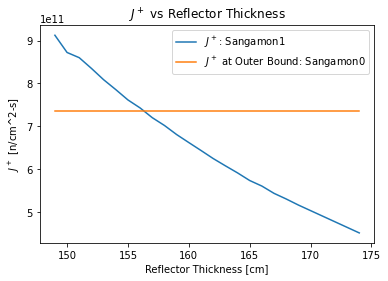

In [18]:
plt.plot(rdet,joutc)
plt.plot(rdet, J_200c*np.ones(len(rdet)))
plt.title("$J^+$ vs Reflector Thickness")
plt.xlabel("Reflector Thickness [cm]")
plt.ylabel("$J^+$ [n/cm^2-s]")
plt.legend(["$J^+$: Sangamon1","$J^+$ at Outer Bound: Sangamon0"])

Text(0, 0.5, '$k_{eff}$')

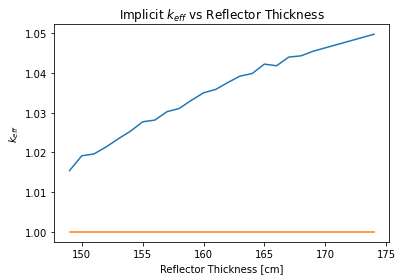

In [19]:
plt.plot(rdet,imp_keff)
plt.plot(rdet,np.ones(len(rdet)))
plt.title("Implicit $k_{eff}$ vs Reflector Thickness")
plt.xlabel("Reflector Thickness [cm]")
plt.ylabel("$k_{eff}$")